In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Loading Dataset

In [2]:
!cp -r '/content/drive/MyDrive/Deep learning Project/Virus Dataset' /content/

In [3]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications import DenseNet121,Xception
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import PIL
from tensorflow.keras.regularizers import l2


In [4]:
import os

def get_class_names(dataset_dir):
    class_names = sorted(
        [d.name for d in os.scandir(dataset_dir) if d.is_dir()]
    )
    return class_names

# Example Usage
train_dir = "/content/Virus Dataset/train"
class_labels_names = get_class_names(train_dir)
print("Class Names:", class_labels_names)


Class Names: ['Adenovirus', 'Astrovirus', 'CCHF', 'Cowpox', 'Ebola', 'Influenza', 'Lassa', 'Marburg', 'Nipah virus', 'Norovirus', 'Orf', 'Papilloma', 'Rift Valley', 'Rotavirus']


In [5]:
IMG_HEIGHT, IMG_WIDTH = 128, 128
BATCH_SIZE = 8
EPOCHS = 50
LEARNING_RATE = 0.0001

In [6]:
def load_images_from_directory(folder_path, img_size=(128, 128)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith('.tif'):
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)  # Append label for each image
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names


In [7]:
base_dir = '/content/Virus Dataset'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'
val_dir = f'{base_dir}/validation'

# Load Dataset
train_ds, train_labels, train_classes = load_images_from_directory(train_dir)
val_ds, val_labels, _ = load_images_from_directory(val_dir)
test_ds, test_labels, _ = load_images_from_directory(test_dir)



In [8]:
# Normalize pixels between 0 and 1
def preprocess(features, labels):
    features = tf.cast(features, tf.float32) / 255.0  # Normalize and convert
    return features, labels

train_tensor_ds = tf.data.Dataset.from_tensor_slices((train_ds, train_labels)).map(preprocess)
val_tensor_ds = tf.data.Dataset.from_tensor_slices((val_ds, val_labels)).map(preprocess)
test_tensor_ds = tf.data.Dataset.from_tensor_slices((test_ds, test_labels)).map(preprocess)

In [9]:
# Shuffling and batching data
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 8

train_tensor_ds_non = train_tensor_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
train_tensor_ds = train_tensor_ds.shuffle(5000).batch(batch_size).prefetch(buffer_size=AUTOTUNE)
test_tensor_ds = test_tensor_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)
val_tensor_ds = val_tensor_ds.batch(batch_size).prefetch(buffer_size=AUTOTUNE)

In [15]:
import plotly.express as px
import numpy as np
from collections import Counter

# Concatenate all labels from train, validation, and test splits
all_labels = np.concatenate([train_labels, val_labels, test_labels])

# Count the total occurrences for each class
class_counts = Counter(all_labels)

# Get class names and corresponding counts
class_names = train_classes
class_counts_sorted = [class_counts[i] for i in range(len(class_names))]

# Create a DataFrame for Plotly
data = {
    "Class": class_names,
    "Sample Count": class_counts_sorted
}

# Plot the pie chart
fig = px.pie(
    data_frame=data,
    names="Class",
    values="Sample Count",
    title="Total Samples Per Class Across All Splits",
    color_discrete_sequence=px.colors.qualitative.Set3  # Set a color palette
)

# Customize layout
fig.update_traces(
    textinfo="percent+label",  # Show percentage and label
    pull=[0.1 if count == max(class_counts_sorted) else 0 for count in class_counts_sorted]  # Highlight the largest slice
)

fig.update_layout(
    template="plotly_dark",
    title_font_size=18,
    legend_title="Classes"
)

# Show the plot
fig.show()


In [13]:
import os
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import PIL.Image

# Function to load images from directory
def load_images_from_directory(folder_path, img_size=(128, 128)):
    labels = []
    images = []
    class_names = sorted(os.listdir(folder_path))  # Get class names (alphabetical)
    for label, class_name in enumerate(class_names):
        class_folder = os.path.join(folder_path, class_name)
        if not os.path.isdir(class_folder):
            continue

        for filename in os.listdir(class_folder):
            if filename.endswith('.tif'):  # Only process TIFF images
                img_path = os.path.join(class_folder, filename)
                try:
                    img = PIL.Image.open(img_path).convert("RGB")
                    img = img.resize(img_size)
                    img_array = np.array(img)
                    images.append(img_array)
                    labels.append(label)  # Append label for each image
                except Exception as e:
                    print(f"Error loading image: {img_path}")
                    continue

    images = np.array(images)
    labels = np.array(labels)
    return images, labels, class_names

# Load the dataset
base_dir = '/content/Virus Dataset'
train_dir = f'{base_dir}/train'
test_dir = f'{base_dir}/test'
val_dir = f'{base_dir}/validation'

train_ds, train_labels, train_classes = load_images_from_directory(train_dir)
val_ds, val_labels, _ = load_images_from_directory(val_dir)
test_ds, test_labels, _ = load_images_from_directory(test_dir)

# Helper function to calculate the number of samples per class in the dataset
def calculate_class_counts(labels):
    class_counts = {}
    for label in labels:
        if label in class_counts:
            class_counts[label] += 1
        else:
            class_counts[label] = 1
    return class_counts

# Calculate class counts for train, validation, and test sets
train_class_counts = calculate_class_counts(train_labels)
val_class_counts = calculate_class_counts(val_labels)
test_class_counts = calculate_class_counts(test_labels)

# Prepare data for the pie chart
data = {
    "Class": [],
    "Split": [],
    "Sample Count": []
}

# Add the counts to the data dictionary
for i, class_label in enumerate(train_classes):
    data["Class"].append(class_label)
    data["Split"].append('Train')
    data["Sample Count"].append(train_class_counts.get(i, 0))

    data["Class"].append(class_label)
    data["Split"].append('Validation')
    data["Sample Count"].append(val_class_counts.get(i, 0))

    data["Class"].append(class_label)
    data["Split"].append('Test')
    data["Sample Count"].append(test_class_counts.get(i, 0))

# Convert the dictionary to a DataFrame
class_count_df = pd.DataFrame(data)

# Create subplots (1 row, 3 columns for train, validation, and test splits)
fig = make_subplots(
    rows=1, cols=3,  # 1 row, 3 columns
    shared_yaxes=True,  # Share the y-axis for easier comparison
    subplot_titles=["Train", "Validation", "Test"],
    specs=[[{'type': 'pie'}, {'type': 'pie'}, {'type': 'pie'}]]  # Pie charts for each subplot
)

# Create the pie charts for each split and add to subplots
splits = ['Train', 'Validation', 'Test']

for idx, split in enumerate(splits):
    split_data = class_count_df[class_count_df["Split"] == split]

    # Pie chart for the current split
    pie_trace = go.Pie(
        labels=split_data["Class"],
        values=split_data["Sample Count"],
        name=split,
        hole=0.15,  # Add hole for a donut-style pie chart
        showlegend=(idx == 0)  # Show legend only for the first subplot
    )

    # Add the pie chart to the subplot
    fig.add_trace(pie_trace, row=1, col=idx + 1)

# Update the layout to include the legend
fig.update_layout(
    title="Class Distribution in Train, Validation, and Test Splits",
    template="plotly_dark",
    height=500,
    legend=dict(
        title="Classes",
        orientation="v",  # Vertical legend
        x=1.2,  # Position legend to the right of the plots
        y=0.5
    )
)

# Show the plot
fig.show()


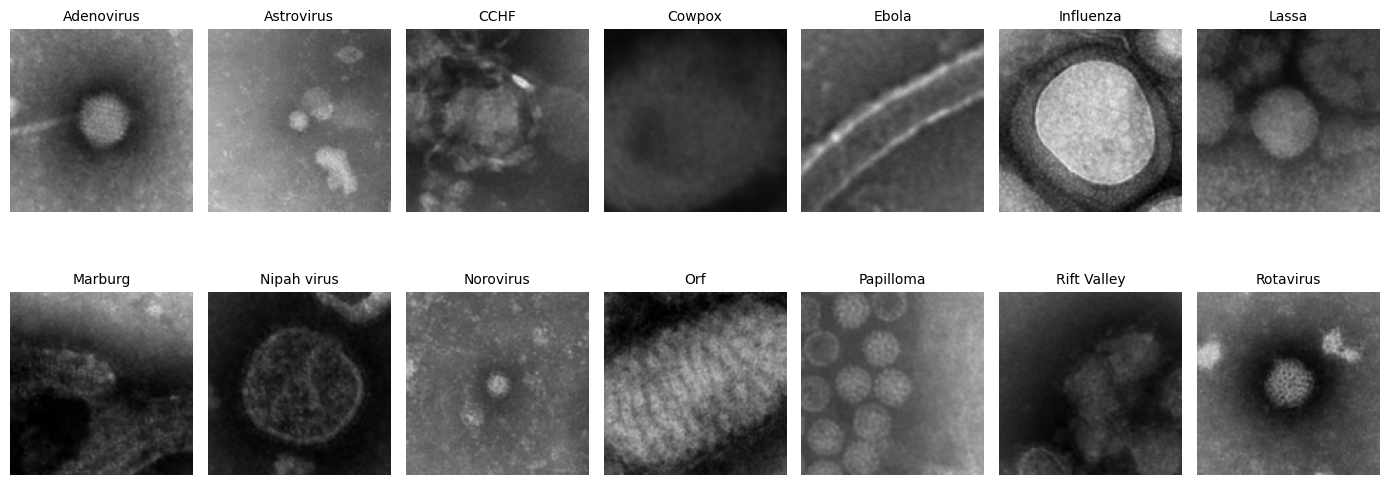

In [14]:
import matplotlib.pyplot as plt
import numpy as np


# Function to select and plot one image from each class
def plot_samples_from_classes(test_ds, class_labels_names):
    # Initialize a dictionary to store the first sample of each class
    class_samples = {}

    # Iterate through the test dataset
    for batch_images, batch_labels in test_ds:
        batch_labels = batch_labels.numpy()  # Convert to numpy
        batch_images = batch_images.numpy()  # Convert to numpy

        # Iterate through each image in the batch
        for img, label in zip(batch_images, batch_labels):
            class_name = class_labels_names[label]

            # Store the first image found for each class
            if class_name not in class_samples:
                class_samples[class_name] = img  # Save the image (first found for each class)

            if len(class_samples) == len(class_labels_names):  # Stop once we have one image per class
                break

        if len(class_samples) == len(class_labels_names):
            break  # Exit the outer loop once all classes have been captured

    # Create the subplot layout (2 rows, 7 columns)
    fig, axes = plt.subplots(2, 7, figsize=(14, 6))
    axes = axes.ravel()  # Flatten axes array for easier indexing

    # Plot each class sample with the corresponding class label
    for idx, (class_name, img) in enumerate(class_samples.items()):
        ax = axes[idx]
        ax.imshow(img)
        ax.set_title(class_name, fontsize=10)
        ax.axis('off')  # Hide axis

    # Adjust layout for better visualization
    plt.tight_layout()
    plt.show()

# Call the function to plot samples from each class
plot_samples_from_classes(test_tensor_ds, class_labels_names)


# Loading the Models adn There histories

In [34]:
# Pickle file
ResNet18_history_path_Adam = '/content/drive/MyDrive/Deep learning Project/ResNet/ResNet18TrainingHistoryBeforSGD.pkl'
with open(ResNet18_history_path_Adam, 'rb') as f:  # Use 'rb' for reading binary files
    ResNet18_history_Adam = pickle.load(f)
print("Training history of ResNet18 with Adam model loaded successfully!")

# Pickle file
ResNet34_history_path = '/content/drive/MyDrive/Deep learning Project/ResNet/ResNet34TrainingHistory.pkl'
with open(ResNet34_history_path, 'rb') as f:  # Use 'rb' for reading binary files
    ResNet34_history = pickle.load(f)
print("Training history of ResNet34 model loaded successfully!")

# Pickle file
ResNet50_history_path = '/content/drive/MyDrive/Deep learning Project/ResNet/ResNet50TrainingHistory.pkl'
with open(ResNet50_history_path, 'rb') as f:  # Use 'rb' for reading binary files
    ResNet50_history = pickle.load(f)
print("Training history of ResNet50 model loaded successfully!")

Training history of ResNet18 with Adam model loaded successfully!
Training history of ResNet34 model loaded successfully!
Training history of ResNet50 model loaded successfully!


In [41]:
import pandas as pd
import plotly.express as px

# Convert ResNet18_history to a dictionary
resnet18_history_dict_Adam = ResNet18_history_Adam.history
resnet34_history_dict = ResNet34_history
resnet50_history_dict = ResNet50_history

# 1. Extract epoch ranges
resnet18_epochs_Adam = range(1, len(resnet18_history_dict_Adam['accuracy']) + 1)
resnet34_epochs = range(1, len(resnet34_history_dict['accuracy']) + 1)
resnet50_epochs = range(1, len(resnet50_history_dict['accuracy']) + 1)

# 2. Prepare data for Xception
resnet18_data_Adam = pd.DataFrame({
    'Epoch': resnet18_epochs_Adam,
    'Training Accuracy': resnet18_history_dict_Adam['accuracy'],
    'Validation Accuracy': resnet18_history_dict_Adam['val_accuracy'],
    'Training Loss': resnet18_history_dict_Adam['loss'],
    'Validation Loss': resnet18_history_dict_Adam['val_loss'],
    'Model': 'Xception'
})

# 3. Prepare data for DenseNet121
resnet34_data = pd.DataFrame({
    'Epoch': resnet34_epochs,
    'Training Accuracy': resnet34_history_dict['accuracy'],
    'Validation Accuracy': resnet34_history_dict['val_accuracy'],
    'Training Loss': resnet34_history_dict['loss'],
    'Validation Loss': resnet34_history_dict['val_loss'],
    'Model': 'DenseNet121'
})

# 4. Prepare data for ResNet18
resnet50_data = pd.DataFrame({
    'Epoch': resnet50_epochs,
    'Training Accuracy': resnet50_history_dict['accuracy'],
    'Validation Accuracy': resnet50_history_dict['val_accuracy'],
    'Training Loss': resnet50_history_dict['loss'],
    'Validation Loss': resnet50_history_dict['val_loss'],
    'Model': 'ResNet18'
})

# 5. Combine all datasets
combined_data = pd.concat([resnet18_data_Adam, resnet34_data, resnet50_data], axis=0)

# 6. Melt the data to long format for easier plotting
accuracy_data = combined_data.melt(
    id_vars=['Epoch', 'Model'],
    value_vars=['Training Accuracy', 'Validation Accuracy'],
    var_name='Metric',
    value_name='Accuracy'
)

loss_data = combined_data.melt(
    id_vars=['Epoch', 'Model'],
    value_vars=['Training Loss', 'Validation Loss'],
    var_name='Metric',
    value_name='Loss'
)

# 7. Plot accuracy using Plotly Express
fig_accuracy = px.line(
    accuracy_data,
    x='Epoch',
    y='Accuracy',
    color='Model',
    line_dash='Metric',
    title='Training and Validation Accuracy for Xception, DenseNet121, and ResNet18',
    template='plotly_dark',  # Dark theme for better contrast
    color_discrete_map={
        'Xception': '#1f77b4',   # Blue
        'DenseNet121': '#ff7f0e',  # Orange
        'ResNet18': '#2ca02c'    # Green
    }
)

fig_accuracy.update_traces(line_width=3)  # Make lines bolder
fig_accuracy.show()

# 8. Plot loss using Plotly Express
fig_loss = px.line(
    loss_data,
    x='Epoch',
    y='Loss',
    color='Model',
    line_dash='Metric',
    title='Training and Validation Loss for Xception, DenseNet121, and ResNet18',
    template='plotly_dark',  # Dark theme for better contrast
    color_discrete_map={
        'Xception': '#1f77b4',   # Blue
        'DenseNet121': '#ff7f0e',  # Orange
        'ResNet18': '#2ca02c'    # Green
    }
)

fig_loss.update_traces(line_width=3)  # Make lines bolder
fig_loss.show()


In [42]:
# Pickle file
ResNet18_history_path = '/content/drive/MyDrive/Deep learning Project/ResNet/ResNet18TrainingHistory.pkl'
with open(ResNet18_history_path, 'rb') as f:  # Use 'rb' for reading binary files
    ResNet18_history = pickle.load(f)
print("Training history of ResNet18 model loaded successfully!")

Training history of ResNet18 model loaded successfully!


In [47]:
import pandas as pd
import plotly.express as px

# Convert ResNet18_history to a dictionary
resnet18_history_dict_Adam = ResNet18_history_Adam.history
resnet18_history_dict = ResNet18_history.history

# 1. Extract epoch ranges
resnet18_epochs_Adam = range(1, len(resnet18_history_dict_Adam['accuracy']) + 1)
resnet18_epochs = range(1, len(resnet18_history_dict['accuracy']) + 1)


# 2. Prepare data for Xception
resnet18_data_Adam = pd.DataFrame({
    'Epoch': resnet18_epochs_Adam,
    'Training Accuracy': resnet18_history_dict_Adam['accuracy'],
    'Validation Accuracy': resnet18_history_dict_Adam['val_accuracy'],
    'Training Loss': resnet18_history_dict_Adam['loss'],
    'Validation Loss': resnet18_history_dict_Adam['val_loss'],
    'Model': 'Xception'
})

# 3. Prepare data for DenseNet121
resnet18_data = pd.DataFrame({
    'Epoch': resnet18_epochs,
    'Training Accuracy': resnet18_history_dict['accuracy'],
    'Validation Accuracy': resnet18_history_dict['val_accuracy'],
    'Training Loss': resnet18_history_dict['loss'],
    'Validation Loss': resnet18_history_dict['val_loss'],
    'Model': 'DenseNet121'
})


# 5. Combine all datasets
combined_data = pd.concat([resnet18_data_Adam, resnet18_data], axis=0)

# 6. Melt the data to long format for easier plotting
accuracy_data = combined_data.melt(
    id_vars=['Epoch', 'Model'],
    value_vars=['Training Accuracy', 'Validation Accuracy'],
    var_name='Metric',
    value_name='Accuracy'
)

loss_data = combined_data.melt(
    id_vars=['Epoch', 'Model'],
    value_vars=['Training Loss', 'Validation Loss'],
    var_name='Metric',
    value_name='Loss'
)

# 7. Plot accuracy using Plotly Express
fig_accuracy = px.line(
    accuracy_data,
    x='Epoch',
    y='Accuracy',
    color='Model',
    line_dash='Metric',
    title='Training and Validation Accuracy for ResNet18 architecture with difference two optimizers',
    template='plotly_dark',  # Dark theme for better contrast
    color_discrete_map={
        'Adam': '#1f77b4',   # Blue
        'SGD': '#ff7f0e'  # Orange
    }
)

fig_accuracy.update_traces(line_width=3)  # Make lines bolder
fig_accuracy.show()

# 8. Plot loss using Plotly Express
fig_loss = px.line(
    loss_data,
    x='Epoch',
    y='Loss',
    color='Model',
    line_dash='Metric',
    title='Training and Validation Loss for ResNet18 architecture with difference two optimizers',
    template='plotly_dark',  # Dark theme for better contrast
    color_discrete_map={
        'Adam': '#1f77b4',   # Blue
        'SGD': '#ff7f0e'  # Orange
    }
)

fig_loss.update_traces(line_width=3)  # Make lines bolder
fig_loss.show()


In [11]:
import json
import pickle
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint

# 1. Load the saved models
Xception_model_path = '/content/drive/MyDrive/Deep learning Project/Xception/Xception.h5'
Xception = tf.keras.models.load_model(Xception_model_path)
print("Xception loaded successfully!")

DenseNet121_model_path = '/content/drive/MyDrive/Deep learning Project/DenseNet121/DenseNet121.h5'
DenseNet121 = tf.keras.models.load_model(DenseNet121_model_path)
print("DenseNet121 loaded successfully!")

ResNet18_model_path = '/content/drive/MyDrive/Deep learning Project/ResNet/ResNet18.h5'
ResNet18 = tf.keras.models.load_model(ResNet18_model_path)
print("ResNet18 loaded successfully!")
# 2. Load the saved training histories
# JSON files
Xception_history_path = '/content/drive/MyDrive/Deep learning Project/Xception/XceptionTrainingHistory.json'
with open(Xception_history_path, 'r') as f:
    Xception_history = json.load(f)
print("Training history of Xception model loaded successfully!")

DenseNet121_history_path = '/content/drive/MyDrive/Deep learning Project/DenseNet121/DenseNet121TrainingHistory.json'
with open(DenseNet121_history_path, 'r') as f:
    DenseNet121_history = json.load(f)
print("Training history of DenseNet121 model loaded successfully!")




Xception loaded successfully!


DenseNet121 loaded successfully!


ResNet18 loaded successfully!
Training history of Xception model loaded successfully!
Training history of DenseNet121 model loaded successfully!


In [18]:
ResNet18.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_36 (Conv2D)        │ (None, 64, 64, 64)     │          9,472 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_36    │ (None, 64, 64, 64)     │            256 │ conv2d_36[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_33 (ReLU)           │ (None, 64, 64, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d_1           │ (None, 32, 32, 64)     │              0 │ re_lu_33[0][0]         │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_37 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_37    │ (None, 32, 32, 64)     │            256 │ conv2d_37[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_34 (ReLU)           │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_38 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ re_lu_34[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_38    │ (None, 32, 32, 64)     │            256 │ conv2d_38[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ add_16 (Add)              │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
│                           │                        │                │ max_pooling2d_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_35 (ReLU)           │ (None, 32, 32, 64)     │              0 │ add_16[0][0]           │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_39 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ re_lu_35[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_39    │ (None, 32, 32, 64)     │            256 │ conv2d_39[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_36 (ReLU)           │ (None, 32, 32, 64)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_40 (Conv2D)        │ (None, 32, 32, 64)     │         36,928 │ re_lu_36[0][0]         │
├──────────────────────

 Total params: 11,198,095 (42.72 MB)

 Trainable params: 11,188,494 (42.68 MB)

 Non-trainable params: 9,600 (37.50 KB)

 Optimizer params: 1 (8.00 B)

In [19]:
DenseNet121.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 128, 128, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 134, 134, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 64, 64, 64)     │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 64, 64, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 64, 64, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 66, 66, 64)     │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 32, 32, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 32, 32, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 32, 32, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 32, 32, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 32, 32, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 32, 32, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 32, 32, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 32, 32, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,569,488 (28.88 MB)

 Trainable params: 899,150 (3.43 MB)

 Non-trainable params: 6,670,336 (25.45 MB)

 Optimizer params: 2 (12.00 B)

In [21]:
Xception.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 128, 128, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1 (Conv2D)     │ (None, 63, 63, 32)     │            864 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_bn           │ (None, 63, 63, 32)     │            128 │ block1_conv1[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv1_act          │ (None, 63, 63, 32)     │              0 │ block1_conv1_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2 (Conv2D)     │ (None, 61, 61, 64)     │         18,432 │ block1_conv1_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_bn           │ (None, 61, 61, 64)     │            256 │ block1_conv2[0][0]     │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1_conv2_act          │ (None, 61, 61, 64)     │              0 │ block1_conv2_bn[0][0]  │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1           │ (None, 61, 61, 128)    │          8,768 │ block1_conv2_act[0][0] │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv1_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv1[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_act       │ (None, 61, 61, 128)    │              0 │ block2_sepconv1_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2           │ (None, 61, 61, 128)    │         17,536 │ block2_sepconv2_act[0… │
│ (SeparableConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_sepconv2_bn        │ (None, 61, 61, 128)    │            512 │ block2_sepconv2[0][0]  │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 31, 31, 128)    │          8,192 │ block1_conv2_act[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block2_pool               │ (None, 31, 31, 128)    │              0 │ block2_sepconv2_bn[0]… │
│ (MaxPooling2D)            │                        │                │                        │
├──────────────────────

 Total params: 21,917,752 (83.61 MB)

 Trainable params: 8,382,646 (31.98 MB)

 Non-trainable params: 13,535,104 (51.63 MB)

 Optimizer params: 2 (12.00 B)

### Predicting the models on random sanples from the Test split

Plot saved to high_res_plot_colored_bold_titles.png with dpi=180


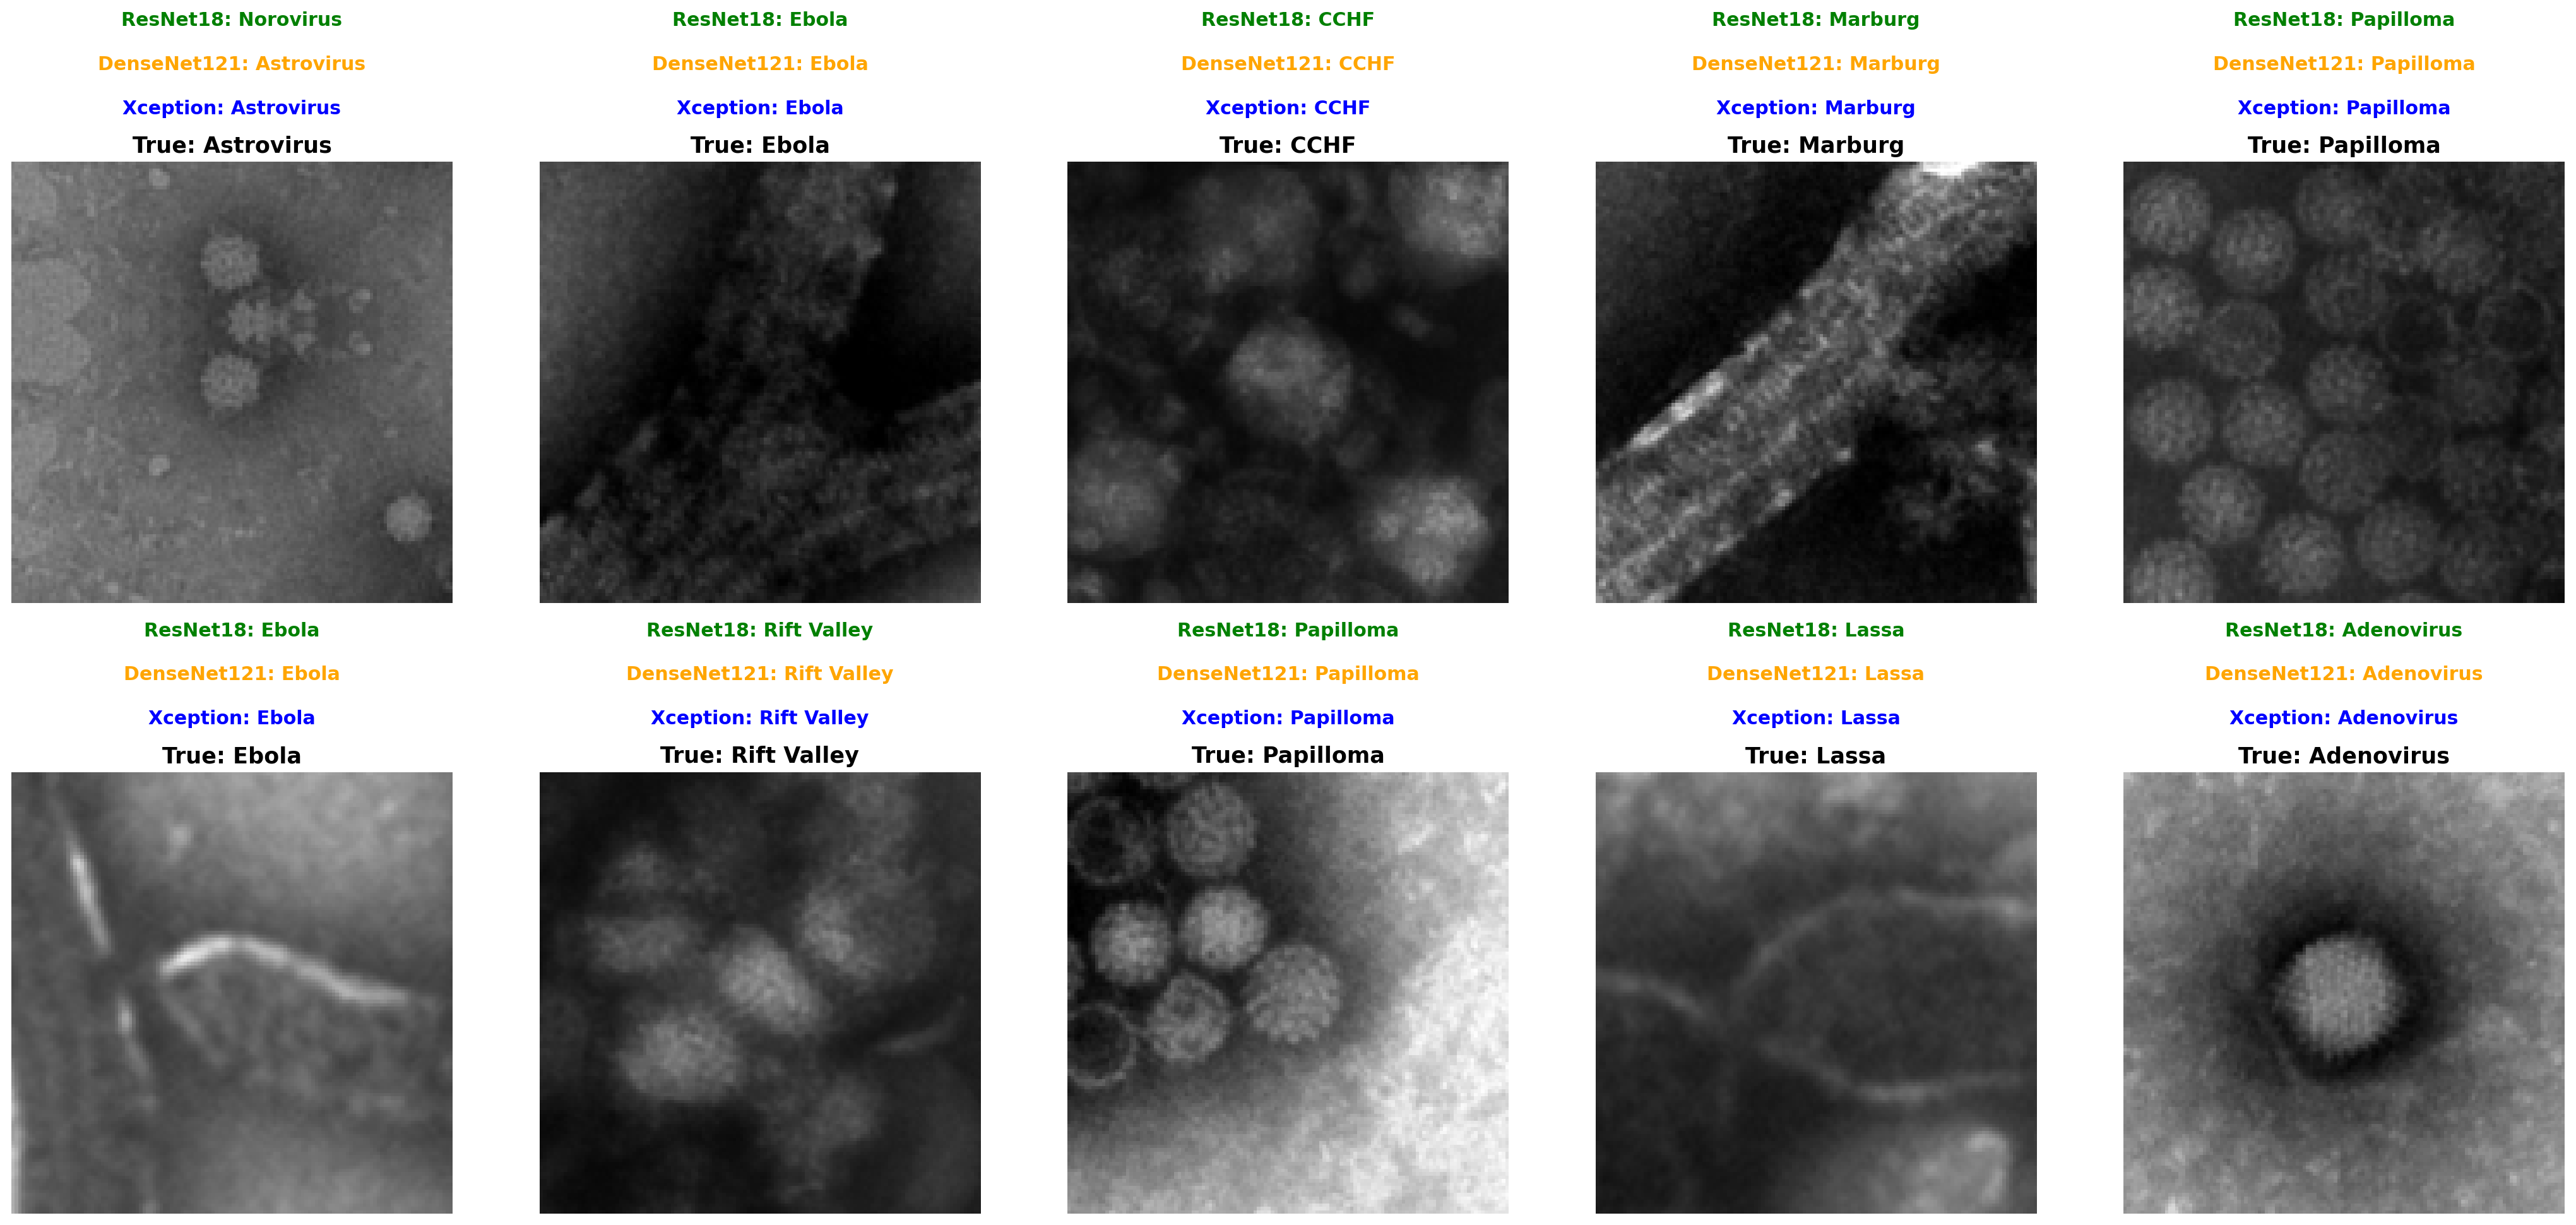

In [80]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import random


def plot_random_predictions_from_tensor_ds(test_tensor_ds, models, class_labels_names, num_samples=10, save_path=None, dpi=300):
    # Convert the test_tensor_ds to a list of batches for random access
    all_images, all_labels = [], []
    for features, labels in test_tensor_ds:
        all_images.extend(features.numpy())
        all_labels.extend(labels.numpy())

    # Ensure we have enough samples to draw from
    num_samples = min(num_samples, len(all_images))

    # Select random indices safely
    random_indices = random.sample(range(len(all_images)), num_samples)

    # Define model colors
    model_colors = {
        'Xception': 'blue',
        'DenseNet121': 'orange',
        'ResNet18': 'green'
    }

    # Create a figure with subplots
    plt.figure(figsize=(24, 12), dpi=dpi)  # High-resolution figure with increased dpi

    # Iterate through random samples
    for i, idx in enumerate(random_indices, 1):
        plt.subplot(2, 5, i)

        # Get the image and true label
        image = all_images[idx]
        true_label = all_labels[idx]
        true_class_name = class_labels_names[true_label]

        # Prepare the image for prediction (add batch dimension)
        input_image = tf.expand_dims(image, axis=0)

        # Get predictions from models
        model_predictions = []
        model_names = ['Xception', 'DenseNet121', 'ResNet18']

        for model, model_name in zip(models, model_names):
            try:
                pred = model.predict(input_image, verbose = False)
                pred_class = np.argmax(pred)
                pred_class_name = class_labels_names[pred_class]
                model_predictions.append((model_name, pred_class_name))
            except Exception as e:
                model_predictions.append((model_name, "Error"))

        # Plot the image
        plt.imshow(image)
        plt.axis('off')

        # Display predictions above the image
        y_offset = 1.1  # Start above the image
        for model_name, pred_class_name in model_predictions:
            plt.text(
                0.5, y_offset,  # Position relative to the image
                f"{model_name}: {pred_class_name}",
                color=model_colors[model_name],
                fontsize=12,
                ha='center',
                va='bottom',
                transform=plt.gca().transAxes,  # Align text relative to the image
                fontweight='bold'  # Make text bold
            )
            y_offset += 0.1  # Adjust spacing between model predictions

        # Add the true label as the title
        plt.title(f"True: {true_class_name}", fontsize=14, fontweight='bold')  # Bold true label title

    # Adjust layout to avoid overlap
    plt.tight_layout(pad=5.5)  # Add extra padding between plots

    # Save or show the plot
    if save_path:
        plt.savefig(save_path, dpi=dpi, bbox_inches="tight")  # Save with high resolution
        print(f"Plot saved to {save_path} with dpi={dpi}")
    else:
        plt.show()


# Usage
# Assuming you have already loaded your models and prepared your test_tensor_ds dataset
models = [Xception, DenseNet121, ResNet18]
plot_random_predictions_from_tensor_ds(
    test_tensor_ds,
    models,
    class_labels_names,
    save_path="high_res_plot_colored_bold_titles.png",  # Specify path to save as an image file
    dpi=180  # High resolution
)


# History of training plocess

In [16]:
import pandas as pd
import plotly.express as px

# Convert ResNet18_history to a dictionary
resnet18_history_dict = ResNet18_history.history

# 1. Extract epoch ranges
xception_epochs = range(1, len(Xception_history['accuracy']) + 1)
densenet_epochs = range(1, len(DenseNet121_history['accuracy']) + 1)
resnet_epochs = range(1, len(resnet18_history_dict['accuracy']) + 1)

# 2. Prepare data for Xception
xception_data = pd.DataFrame({
    'Epoch': xception_epochs,
    'Training Accuracy': Xception_history['accuracy'],
    'Validation Accuracy': Xception_history['val_accuracy'],
    'Training Loss': Xception_history['loss'],
    'Validation Loss': Xception_history['val_loss'],
    'Model': 'Xception'
})

# 3. Prepare data for DenseNet121
densenet_data = pd.DataFrame({
    'Epoch': densenet_epochs,
    'Training Accuracy': DenseNet121_history['accuracy'],
    'Validation Accuracy': DenseNet121_history['val_accuracy'],
    'Training Loss': DenseNet121_history['loss'],
    'Validation Loss': DenseNet121_history['val_loss'],
    'Model': 'DenseNet121'
})

# 4. Prepare data for ResNet18
resnet_data = pd.DataFrame({
    'Epoch': resnet_epochs,
    'Training Accuracy': resnet18_history_dict['accuracy'],
    'Validation Accuracy': resnet18_history_dict['val_accuracy'],
    'Training Loss': resnet18_history_dict['loss'],
    'Validation Loss': resnet18_history_dict['val_loss'],
    'Model': 'ResNet18'
})

# 5. Combine all datasets
combined_data = pd.concat([xception_data, densenet_data, resnet_data], axis=0)

# 6. Melt the data to long format for easier plotting
accuracy_data = combined_data.melt(
    id_vars=['Epoch', 'Model'],
    value_vars=['Training Accuracy', 'Validation Accuracy'],
    var_name='Metric',
    value_name='Accuracy'
)

loss_data = combined_data.melt(
    id_vars=['Epoch', 'Model'],
    value_vars=['Training Loss', 'Validation Loss'],
    var_name='Metric',
    value_name='Loss'
)

# 7. Plot accuracy using Plotly Express
fig_accuracy = px.line(
    accuracy_data,
    x='Epoch',
    y='Accuracy',
    color='Model',
    line_dash='Metric',
    title='Training and Validation Accuracy for Xception, DenseNet121, and ResNet18',
    template='plotly_dark',  # Dark theme for better contrast
    color_discrete_map={
        'Xception': '#1f77b4',   # Blue
        'DenseNet121': '#ff7f0e',  # Orange
        'ResNet18': '#2ca02c'    # Green
    }
)

fig_accuracy.update_traces(line_width=3)  # Make lines bolder
fig_accuracy.show()

# 8. Plot loss using Plotly Express
fig_loss = px.line(
    loss_data,
    x='Epoch',
    y='Loss',
    color='Model',
    line_dash='Metric',
    title='Training and Validation Loss for Xception, DenseNet121, and ResNet18',
    template='plotly_dark',  # Dark theme for better contrast
    color_discrete_map={
        'Xception': '#1f77b4',   # Blue
        'DenseNet121': '#ff7f0e',  # Orange
        'ResNet18': '#2ca02c'    # Green
    }
)

fig_loss.update_traces(line_width=3)  # Make lines bolder
fig_loss.show()


In [17]:
import plotly.graph_objects as go

# 1. Evaluate Xception model
xception_train_eval = Xception.evaluate(train_tensor_ds, verbose=0)
xception_val_eval = Xception.evaluate(val_tensor_ds, verbose=0)
xception_test_eval = Xception.evaluate(test_tensor_ds, verbose=0)

# 2. Evaluate DenseNet121 model
densenet_train_eval = DenseNet121.evaluate(train_tensor_ds, verbose=0)
densenet_val_eval = DenseNet121.evaluate(val_tensor_ds, verbose=0)
densenet_test_eval = DenseNet121.evaluate(test_tensor_ds, verbose=0)

# 3. Evaluate ResNet18 model
resnet_train_eval = ResNet18.evaluate(train_tensor_ds, verbose=0)
resnet_val_eval = ResNet18.evaluate(val_tensor_ds, verbose=0)
resnet_test_eval = ResNet18.evaluate(test_tensor_ds, verbose=0)

# 4. Organize results in a dictionary
evaluation_results = {
    'Model': ['Xception', 'Xception', 'Xception', 'DenseNet121', 'DenseNet121', 'DenseNet121', 'ResNet18', 'ResNet18', 'ResNet18'],
    'Dataset': ['Train', 'Validation', 'Test', 'Train', 'Validation', 'Test', 'Train', 'Validation', 'Test'],
    'Loss': [xception_train_eval[0], xception_val_eval[0], xception_test_eval[0],
             densenet_train_eval[0], densenet_val_eval[0], densenet_test_eval[0],
             resnet_train_eval[0], resnet_val_eval[0], resnet_test_eval[0]],
    'Accuracy': [xception_train_eval[1], xception_val_eval[1], xception_test_eval[1],
                 densenet_train_eval[1], densenet_val_eval[1], densenet_test_eval[1],
                 resnet_train_eval[1], resnet_val_eval[1], resnet_test_eval[1]]
}

# 5. Visualize results using Plotly
fig = go.Figure()

# Add traces for Xception
fig.add_trace(go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=[xception_train_eval[1], xception_val_eval[1], xception_test_eval[1]],
    name='Xception Accuracy',
    marker_color='#1f77b4'  # Blue
))

fig.add_trace(go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=[xception_train_eval[0], xception_val_eval[0], xception_test_eval[0]],
    name='Xception Loss',
    marker_color='#87CEEB'  # Light Blue
))

# Add traces for DenseNet121
fig.add_trace(go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=[densenet_train_eval[1], densenet_val_eval[1], densenet_test_eval[1]],
    name='DenseNet121 Accuracy',
    marker_color='#ff7f0e'  # Orange
))

fig.add_trace(go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=[densenet_train_eval[0], densenet_val_eval[0], densenet_test_eval[0]],
    name='DenseNet121 Loss',
    marker_color='#FFD580'  # Light Orange
))

# Add traces for ResNet18
fig.add_trace(go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=[resnet_train_eval[1], resnet_val_eval[1], resnet_test_eval[1]],
    name='ResNet18 Accuracy',
    marker_color='#2ca02c'  # Green
))

fig.add_trace(go.Bar(
    x=['Train', 'Validation', 'Test'],
    y=[resnet_train_eval[0], resnet_val_eval[0], resnet_test_eval[0]],
    name='ResNet18 Loss',
    marker_color='#98FB98'  # Light Green
))

# Customize layout
fig.update_layout(
    title="Model Evaluation Results (Train, Validation, Test)",
    xaxis_title="Dataset",
    yaxis_title="Metrics",
    barmode='group',  # Group bars side by side
    template='plotly_dark'
)

# Show the plot
fig.show()

In [49]:
import time

# Step 2: Measure prediction times for each model
prediction_times = {}  # To store the prediction times

# Use test_tensor_ds for predictions
# Measure prediction time for Xception
start_time = time.time()
Xception.predict(test_tensor_ds, verbose=0)
end_time = time.time()
prediction_times['Xception'] = end_time - start_time

# Measure prediction time for DenseNet121
start_time = time.time()
DenseNet121.predict(test_tensor_ds, verbose=0)
end_time = time.time()
prediction_times['DenseNet121'] = end_time - start_time

# Measure prediction time for ResNet18
start_time = time.time()
ResNet18.predict(test_tensor_ds, verbose=0)
end_time = time.time()
prediction_times['ResNet18'] = end_time - start_time

# Step 3: Prepare data for plotting
data = pd.DataFrame({
    'Model': list(prediction_times.keys()),
    'Prediction Time (seconds)': list(prediction_times.values())
})

# Step 4: Plot the results using Plotly Express
fig = px.bar(
    data,
    x='Model',
    y='Prediction Time (seconds)',
    color='Model',
    title='Comparison of Prediction Times for Xception, DenseNet121, and ResNet18',
    text='Prediction Time (seconds)',
    template='plotly_dark'  # Optional: dark theme
)

# Customize the bar chart
fig.update_traces(texttemplate='%{text:.2f}s', textposition='outside')
fig.update_layout(yaxis_title='Time (seconds)', xaxis_title='Model', showlegend=False)

# Show the plot
fig.show()

In [12]:
import time

# Step 2: Measure prediction times for each model
prediction_times = {}  # To store the prediction times

# Use test_tensor_ds for predictions
# Measure prediction time for Xception
start_time = time.time()
Xception.predict(test_tensor_ds, verbose=0)
end_time = time.time()
prediction_times['Xception'] = end_time - start_time

# Measure prediction time for DenseNet121
start_time = time.time()
DenseNet121.predict(test_tensor_ds, verbose=0)
end_time = time.time()
prediction_times['DenseNet121'] = end_time - start_time

# Measure prediction time for ResNet18
start_time = time.time()
ResNet18.predict(test_tensor_ds, verbose=0)
end_time = time.time()
prediction_times['ResNet18'] = end_time - start_time


NameError: name 'pd' is not defined

In [14]:
import pandas as pd
import plotly.express as px

# Step 3: Prepare data for plotting
data = pd.DataFrame({
    'Model': list(prediction_times.keys()),
    'Prediction Time (seconds)': list(prediction_times.values())
})

# Step 4: Plot the results using Plotly Express
fig = px.bar(
    data,
    x='Model',
    y='Prediction Time (seconds)',
    color='Model',
    title='Comparison of Prediction Times for Xception, DenseNet121, and ResNet18',
    text='Prediction Time (seconds)',
    template='plotly_dark'  # Optional: dark theme
)

# Customize the bar chart
fig.update_traces(texttemplate='%{text:.2f}s', textposition='outside')
fig.update_layout(yaxis_title='Time (seconds)', xaxis_title='Model', showlegend=False)

# Show the plot
fig.show()

In [24]:
import plotly.express as px
import numpy as np
import tensorflow as tf
from sklearn.metrics import confusion_matrix
import pandas as pd
from plotly.subplots import make_subplots  # Import make_subplots

def plot_confusion_matrices_with_plotly(models, train_ds, val_ds, test_ds, train_labels, val_labels, test_labels, class_labels_names):

    model_names = ['Xception', 'DenseNet121', 'ResNet18']
    splits = [(train_ds, train_labels, 'Train'), (val_ds, val_labels, 'Validation'), (test_ds, test_labels, 'Test')]

    fig = make_subplots(
        rows=len(models), cols=len(splits),
        subplot_titles=[f"{model_name} - {split_name} Split" for model_name in model_names for _, _, split_name in splits],
        vertical_spacing=0.1, horizontal_spacing=0.1
    )

    for i, (model, model_name) in enumerate(zip(models, model_names)):
        for j, (split_ds, split_labels, split_name) in enumerate(splits):
            # Get predictions for the split
            pred_labels = []
            for img_batch, _ in split_ds:
                predictions = model.predict(img_batch, verbose=False)
                pred_labels.extend(np.argmax(predictions, axis=1))

            # Compute confusion matrix
            cm = confusion_matrix(split_labels, pred_labels)
            cm_df = pd.DataFrame(cm, index=class_labels_names, columns=class_labels_names)

            # Create heatmap using Plotly Express
            heatmap = px.imshow(
                cm_df,
                text_auto=True,
                labels={'x': 'Predicted Label', 'y': 'True Label'},
                color_continuous_scale='Blues',
                title=f"{model_name} - {split_name} Split"
            )

            # Add heatmap to subplot
            row = i + 1
            col = j + 1
            fig.add_trace(heatmap.data[0], row=row, col=col)

    # Update layout for cleaner x-axis labels
    fig.update_layout(
        height=1500,  # Increase height to accommodate labels
        width=1500,   # Increase width to fit all subplots
        title_text="Confusion Matrices for Each Model on Different Splits",
        showlegend=False,
    )

    # Customize individual heatmaps' x-axis and y-axis label angles
    for i in range(1, len(models) + 1):  # Iterate over rows (models)
        for j in range(1, len(splits) + 1):  # Iterate over columns (splits)
            fig.update_xaxes(
                title_text="Predicted Label",
                tickangle=45,  # Rotate x-axis labels for better readability
                row=i,
                col=j
            )
            fig.update_yaxes(
                title_text="True Label",
                row=i,
                col=j
            )

    # Show the figure
    fig.show()

# Usage
# Assuming you have already loaded your models and datasets (train_ds, val_ds, test_ds, etc.)
models = [Xception, DenseNet121, ResNet18]
plot_confusion_matrices_with_plotly(
    models,
    train_tensor_ds_non,
    val_tensor_ds,
    test_tensor_ds,
    train_labels,
    val_labels,
    test_labels,
    class_labels_names
)


In [23]:
from sklearn.metrics import classification_report
import numpy as np

def print_classification_reports(models, model_names, train_ds, val_ds, test_ds, train_labels, val_labels, test_labels, class_labels_names):

    for model, model_name in zip(models, model_names):
        print(f"Classification Report for {model_name} on Train Split:")
        # Get predictions for the train dataset
        train_preds = []
        for img_batch, _ in train_ds:
            preds = model.predict(img_batch, verbose=False)
            train_preds.extend(np.argmax(preds, axis=1))

        # Print the classification report for the train set
        print(classification_report(train_labels, train_preds, target_names=class_labels_names))

        print(f"\nClassification Report for {model_name} on Validation Split:")
        # Get predictions for the validation dataset
        val_preds = []
        for img_batch, _ in val_ds:
            preds = model.predict(img_batch, verbose=False)
            val_preds.extend(np.argmax(preds, axis=1))

        # Print the classification report for the validation set
        print(classification_report(val_labels, val_preds, target_names=class_labels_names))

        print(f"\nClassification Report for {model_name} on Test Split:")
        # Get predictions for the test dataset
        test_preds = []
        for img_batch, _ in test_ds:
            preds = model.predict(img_batch, verbose=False)
            test_preds.extend(np.argmax(preds, axis=1))

        # Print the classification report for the test set
        print(classification_report(test_labels, test_preds, target_names=class_labels_names))

        print("\n" + "="*100 + "\n")  # Separator for readability

# Example usage:
# Assuming you have already loaded your models and datasets (train_ds, val_ds, test_ds, etc.)
models = [Xception, DenseNet121, ResNet18]
model_names = ['Xception', 'DenseNet121', 'ResNet18']
print_classification_reports(
    models,
    model_names,
    train_tensor_ds_non,
    test_tensor_ds,
    val_tensor_ds,
    train_labels,
    test_labels,
    val_labels,
    class_labels_names
)


Classification Report for Xception on Train Split:
              precision    recall  f1-score   support

  Adenovirus       1.00      1.00      1.00       606
  Astrovirus       1.00      1.00      1.00       621
        CCHF       1.00      1.00      1.00       645
      Cowpox       1.00      1.00      1.00       606
       Ebola       1.00      1.00      1.00      1097
   Influenza       1.00      1.00      1.00       830
       Lassa       1.00      1.00      1.00       684
     Marburg       1.00      1.00      1.00       758
 Nipah virus       1.00      1.00      1.00       567
   Norovirus       1.00      1.00      1.00       646
         Orf       1.00      1.00      1.00       590
   Papilloma       1.00      1.00      1.00       804
 Rift Valley       1.00      1.00      1.00      1079
   Rotavirus       1.00      1.00      1.00       576

    accuracy                           1.00     10109
   macro avg       1.00      1.00      1.00     10109
weighted avg       1.00      

In [16]:
import plotly.express as px
from sklearn.metrics import roc_curve, auc
import numpy as np
import tensorflow as tf

def plot_roc_auc(models, model_names, test_ds, val_ds, test_labels, val_labels, class_labels_names):

    for model, model_name in zip(models, model_names):
        # Get predictions for the test dataset
        test_preds = []
        test_labels_one_hot = tf.keras.utils.to_categorical(test_labels, num_classes=len(class_labels_names))

        for img_batch, _ in test_ds:
            preds = model.predict(img_batch, verbose = False)
            test_preds.extend(preds)

        test_preds = np.array(test_preds)

        # Get ROC and AUC for test data
        fpr, tpr, thresholds = roc_curve(test_labels_one_hot.ravel(), test_preds.ravel())
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for test set
        fig = px.area(
            x=fpr,
            y=tpr,
            title=f'ROC Curve for {model_name} on Test Split (AUC = {roc_auc:.2f})',
            labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'},
            template='plotly_dark'
        )
        fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash', color='gray'), name='Random')
        fig.show()

        # Get predictions for the validation dataset
        val_preds = []
        val_labels_one_hot = tf.keras.utils.to_categorical(val_labels, num_classes=len(class_labels_names))

        for img_batch, _ in val_ds:
            preds = model.predict(img_batch, verbose = False)
            val_preds.extend(preds)

        val_preds = np.array(val_preds)

        # Get ROC and AUC for validation data
        fpr, tpr, thresholds = roc_curve(val_labels_one_hot.ravel(), val_preds.ravel())
        roc_auc = auc(fpr, tpr)

        # Plot ROC curve for validation set
        fig = px.area(
            x=fpr,
            y=tpr,
            title=f'ROC Curve for {model_name} on Validation Split (AUC = {roc_auc:.2f})',
            labels={'x': 'False Positive Rate', 'y': 'True Positive Rate'},
            template='plotly_dark'
        )
        fig.add_scatter(x=[0, 1], y=[0, 1], mode='lines', line=dict(dash='dash', color='gray'), name='Random')
        fig.show()

# Example usage:
# Assuming you have already loaded your models and datasets (train_ds, val_ds, test_ds, etc.)
models = [Xception, DenseNet121, ResNet18]
model_names = ['Xception', 'DenseNet121', 'ResNet18']
plot_roc_auc(
    models,
    model_names,
    test_tensor_ds,
    val_tensor_ds,
    test_labels,
    val_labels,
    class_labels_names
)
